# **1.DATA ACQUISITION**

In [ ]:
#required packages version for tensorflow and keras
#%pip install tensorflow==1.13.1
%pip install tensorflow==1.14
!pip install keras==2.1.0

     |████████████████████████████████| 109.2MB 35kB/s 
     |████████████████████████████████| 491kB 45.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 3.2MB 23.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 307kB 4.6MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# import spacy
import scipy.io
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import json
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Reshape
from tensorflow.keras import Input
#from keras.layers.recurrent import LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.python.keras.layers.merge import Concatenate
from tensorflow.keras.models import model_from_json, Model,Sequential
from tensorflow.keras.utils import plot_model
from collections import defaultdict
import operator
from tensorflow.python.keras.utils import np_utils, generic_utils
#from progressbar import Bar, ETA, Percentage, ProgressBar
from itertools import zip_longest
from tensorflow.keras.models import load_model
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer,one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,CuDNNLSTM,SpatialDropout1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Model,Input
from tensorflow.python.keras.layers.convolutional import Conv2D,Conv1D
from tensorflow.keras import initializers 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow.keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint,TensorBoard
from time import time
from tensorflow.keras.regularizers import l1,l2,l1_l2
from scipy.sparse import hstack
import tensorflow.keras
from tqdm import tqdm
from datetime import datetime
# import cv2
%matplotlib inline
#%tensorflow_version 1.x

import os
os.environ['DISABLE_COLAB_TF_IMPORT_HOOK'] = '1'
import tensorflow as tf
tf.enable_eager_execution()

from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Mounted at /content/drive


In [ ]:
#!wget https://vision.ece.vt.edu/vqa/release_data/mscoco/vqa/mscoco_train2014_annotations.json
#!cp -r '/content/mscoco_train2014_annotations.json' '/content/drive/MyDrive/v2_Questions_Val_mscoco'
#que = json.load(open('v2_OpenEnded_mscoco_train2014_questions.json', 'r'))
#ans = json.load(open('v2_mscoco_train2014_annotations.json', 'r'))
#v2_mscoco_val2014_annotations.json

In [ ]:
que = json.load(open('/content/drive/MyDrive/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json', 'r'))
ans = json.load(open('/content/drive/MyDrive/v2_Annotations_Val_mscoco.zip (Unzipped Files)/v2_mscoco_val2014_annotations.json', 'r'))

In [ ]:
print("Total no. of question are",len(que['questions']))
print("Total no. of answers are",len(ans['annotations']))

Total no. of question are 214354
Total no. of answers are 214354


In [ ]:
from os import listdir
image_dir = '/content/drive/MyDrive/val2015'
images= listdir(image_dir)

In [ ]:
print("Total number of images present in the dataset are", len(images))

Total number of images present in the dataset are 2053


In [ ]:
# CONVERTING DATA FROM JASON TO PANDAS DATAFRAME
subtype='val2014'
data=[]
imdir='%s/COCO_%s_%012d.jpg'
for i in tqdm(range(len(ans['annotations']))):
    answ=ans['annotations'][i]['multiple_choice_answer']
    im_path=imdir%(subtype,subtype,ans['annotations'][i]['image_id'])
    ques=que['questions'][i]['question']
    data.append({'im_path':im_path,'ques':ques,'answ':answ})

100%|██████████| 214354/214354 [00:00<00:00, 501249.04it/s]


In [ ]:
total_data=pd.DataFrame(data)
total_data.im_path = '/content/drive/MyDrive/'+total_data["im_path"] 
total_data.head()

,im_path,ques,answ
0,/content/drive/MyDrive/val2014/COCO_val2014_00...,Where is he looking?,down
1,/content/drive/MyDrive/val2014/COCO_val2014_00...,What are the people in the background doing?,watching
2,/content/drive/MyDrive/val2014/COCO_val2014_00...,What is he on top of?,picnic table
3,/content/drive/MyDrive/val2014/COCO_val2014_00...,What website copyrighted the picture?,foodiebakercom
4,/content/drive/MyDrive/val2014/COCO_val2014_00...,Is this a creamy soup?,no


In [ ]:
total_data.shape

(214354, 3)

# **PREPROCESSING**

In [ ]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
preprocessed_questions = []
for question in tqdm(total_data['ques'].values):
    que = decontracted(question) 
    preprocessed_questions.append(que.lower().strip())

100%|██████████| 214354/214354 [00:01<00:00, 118295.83it/s]


In [ ]:
total_data['ques']=preprocessed_questions
total_data.head(2)

,im_path,ques,answ
0,/content/drive/MyDrive/val2014/COCO_val2014_00...,where is he looking?,down
1,/content/drive/MyDrive/val2014/COCO_val2014_00...,what are the people in the background doing?,watching


In [ ]:
total_data=total_data.reset_index(drop=True)

In [ ]:
a=pd.DataFrame(total_data['answ'].value_counts()[:2])
ind=list(a.index)

In [ ]:
top_data=pd.DataFrame()
for i in tqdm(ind):
    top_data1=total_data[total_data.answ == i]
    top_data=pd.concat([top_data,top_data1],ignore_index=True)

100%|██████████| 2/2 [00:00<00:00, 14.94it/s]


In [ ]:
print("Shape of data after considering top 2 answers is",top_data.shape)

Shape of data after considering top 2 answers is (80810, 3)


In [ ]:
top_data=top_data.sample(40000).reset_index(drop=True)

In [ ]:
print("Shape of data after considering top 2 answers is",top_data.shape)

Shape of data after considering top 2 answers is (40000, 3)


In [ ]:
top_data.head(2)

,im_path,ques,answ
0,/content/drive/MyDrive/val2014/COCO_val2014_00...,is the tram full of people?,yes
1,/content/drive/MyDrive/val2014/COCO_val2014_00...,is this man riding a wave?,yes


# **Exploratory Data Analysis**

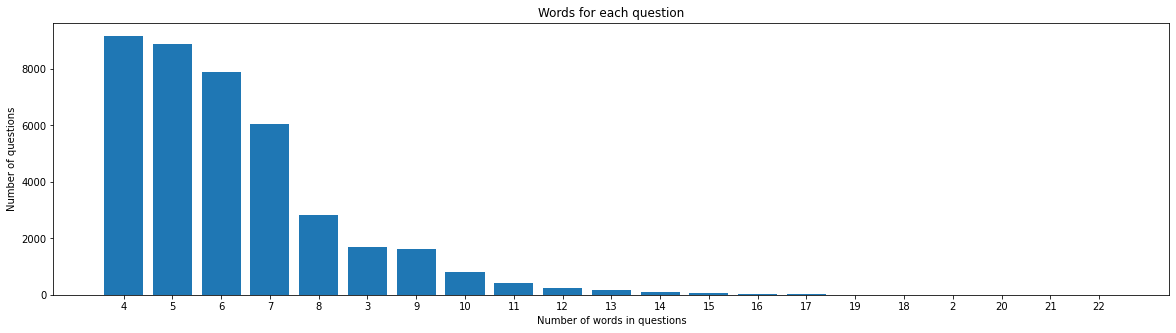

In [ ]:
word_count = top_data['ques'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of questions')
plt.xlabel('Number of words in questions')
plt.title('Words for each question')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

Observations:
1. Most of the question length is 4 to 8 words.
2. Maximum length of question is 22 words.

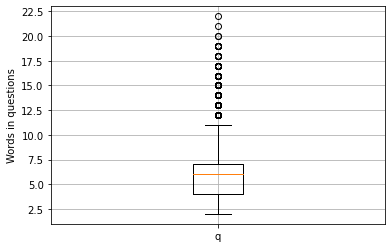

In [ ]:
que_word_count = top_data['ques'].str.split().apply(len)
plt.boxplot(que_word_count)
plt.xticks([1],'questions')
plt.ylabel('Words in questions')
plt.grid()
plt.show()

Observations:
1. 50% questions have 5 to 8 words.
2. Most of the questions have less than 10 words although there are few questions having greater than 10 words.

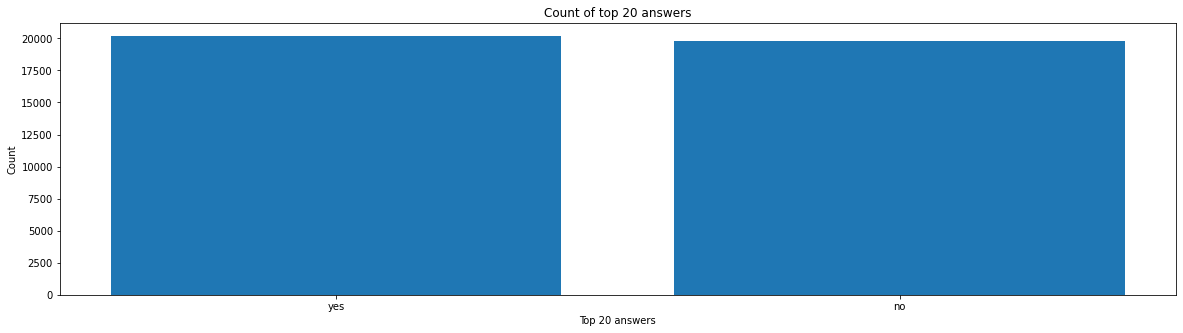

In [ ]:
word_count = top_data['answ'].value_counts()[0:20]
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Count')
plt.xlabel('Top 20 answers')
plt.title('Count of top 20 answers')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

Observations:
1. Very large proportion of the answer have yes/no answer.
2. Apart from binary answers  most common answes constists of either colors or numbers

In [ ]:
cnt1= top_data[top_data['answ']=='yes']['answ'].count()+top_data[top_data['answ']=='no']['answ'].count()
cnt2= len(top_data)-cnt1
print("Total no of binary(yes/no) answers  :",cnt1)
print("% of binary answers                 :",np.round(cnt1/len(top_data)*100,2))
print("Total no of multiple answers        :",cnt2)
print("% of multiple answers               :",np.round(cnt2/len(top_data)*100,2))

Total no of binary(yes/no) answers  : 40000
% of binary answers                 : 100.0
Total no of multiple answers        : 0
% of multiple answers               : 0.0


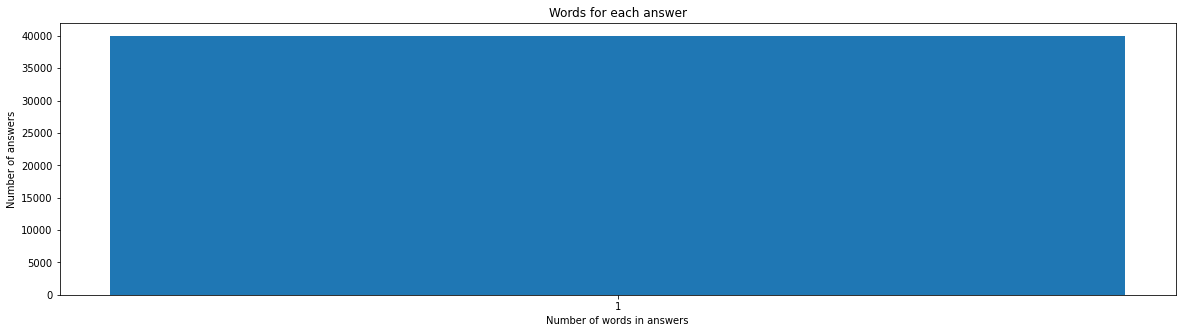

In [ ]:
word_count = top_data['answ'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of answers')
plt.xlabel('Number of words in answers')
plt.title('Words for each answer')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

Observations:
1. Almost 95% answers are one word answers although few questions have 2,3 and 4 word answers.

In [ ]:

#top_data.drop(['answ'],axis=1,inplace=True)

In [35]:
x_train=pd.read_csv('/content/drive/MyDrive/data/x_train.csv')
x_test=pd.read_csv('/content/drive/MyDrive/data/x_test.csv')
y_train=pd.read_csv('/content/drive/MyDrive/data/y_train.csv')
y_test=pd.read_csv('/content/drive/MyDrive/data/y_test.csv')

In [36]:
y_train.drop(['Unnamed: 0'],axis=1,inplace=True)

In [37]:
y_test.drop(['Unnamed: 0'],axis=1,inplace=True)

In [38]:
!pip uninstall keras-preprocessing

Uninstalling Keras-Preprocessing-1.1.2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras_Preprocessing-1.1.2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/keras_preprocessing/*
Proceed (y/n)? y
  Successfully uninstalled Keras-Preprocessing-1.1.2


In [ ]:
pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-12ig7fe3
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-12ig7fe3
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-cp36-none-any.whl size=43074 sha256=07c0d3ef4d13ca80d35bc18e402edfac14d4cad1176b241a2356126c5dc41c0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zrcu7w86/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array

# **ENCODING QUESTIONS**

In [ ]:
def textokenizer(text):
  max_length = 24
  tok = Tokenizer()
  tok.fit_on_texts(x_train['ques'])
  vocab_size = len(tok.word_index) + 1
  #print('Total unique words in the x_train',vocab_size)
  encoded_text = tok.texts_to_sequences(text)
  padded_text = pad_sequences(encoded_text, maxlen=max_length)  #padding zeros at the begining of each question so that each sequence will have same length
  #print(padded_text.shape)
  return padded_text, tok

In [ ]:
#!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!cp -r '/content/glove.6B.zip' '/content/drive/MyDrive/data'
#!unzip /content/drive/MyDrive/data/glove.6B.zip
#!cp -r '/content/glove.6B.300d.txt' '/content/drive/MyDrive/data'
#!unzip '/content/drive/MyDrive/data/glove.840B.300d.pkl.zip'
#!cp -r '/content/glove.840B.300d.pkl' '/content/drive/MyDrive/data'

In [ ]:
#from gensim.scripts.glove2word2vec import glove2word2vec
#glove2word2vec(glove_input_file="/content/drive/MyDrive/data/glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")
#!cp -r '/content/gensim_glove_vectors.txt' '/content/drive/MyDrive/data'
#from gensim.models.keyedvectors import KeyedVectors
#glove_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/data/gensim_glove_vectors.txt", binary=False)

In [ ]:
#Each token is represented using 300-dim vector using pre-trained GloVe representation.
with open('/content/drive/MyDrive/data/glove.840B.300d.pkl', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
# for train
_,tok = textokenizer(x_train['ques'])
vocab_size = len(tok.word_index) + 1
embedding_matrix_train = np.zeros((vocab_size, 300))
for word, i in tok.word_index.items():
    if word in glove_words:
        embedding_vector = model[word]
        embedding_matrix_train[i] = embedding_vector

In [ ]:
print("embedding matrix shape",embedding_matrix_train.shape)

embedding matrix shape (112, 300)


# **ENCODING ANSWERS**

In [ ]:
def optokens(classes):
  from sklearn.preprocessing import OneHotEncoder
  ohe=OneHotEncoder(handle_unknown='ignore')
  ohe.fit(y_train.values.reshape(-1,1))
  optoken=ohe.transform(classes.values.reshape(-1,1)).toarray()
  return optoken, ohe

In [ ]:
_,ohe=optokens(x_train['answ'])

In [ ]:
pickle.dump(ohe,open('/content/drive/MyDrive/data/ohe.pkl','wb'))

# **CREATING DATASET**

In [ ]:
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Input,Add,MaxPool2D,Flatten,AveragePooling2D,Dense,BatchNormalization,ZeroPadding2D,Activation,Concatenate,UpSampling2D
from tensorflow.keras.models import Model
model = VGG16(weights='imagenet')
feature_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467904/553467096 [==============================] - 12s 0us/step


In [ ]:
len(set(top_data['im_path'].tolist()))

27

In [ ]:
def parse_function(filename):
    image_string = tf.io.read_file(filename)
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return  image, filename

In [ ]:
img_fl = sorted(set(top_data['im_path'].tolist()))
img_fl[1]

'/content/drive/MyDrive/val2014/COCO_val2014_000000000196.jpg'

In [ ]:
img_fl=sorted(set(top_data['im_path'].tolist()))
img_data_tr=tf.data.Dataset.from_tensor_slices(img_fl)
img_data_tr=img_data_tr.map(parse_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
for img, path in tqdm(img_data_tr):
  batch_features = feature_model(img)
  #batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

1it [00:20, 20.03s/it]


In [ ]:
ques_train , _ =textokenizer(x_train['ques'])
answ_train , _ =optokens(x_train['answ'])
ques_train=ques_train.tolist()
answ_train=answ_train.tolist()

In [ ]:
ques_train=ques_train.tolist()
answ_train=answ_train.tolist()

In [ ]:
def map_func(img_name, question):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, question

In [ ]:
img_fl=x_train['im_path'].tolist()
train_dataset = tf.data.Dataset.from_tensor_slices((img_fl, ques_train))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
op_train_dataset = tf.data.Dataset.from_tensor_slices(answ_train)
train_dataset=tf.data.Dataset.zip((train_dataset,op_train_dataset))
train_dataset = train_dataset.batch(1000)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
ques_test,_=textokenizer(x_test['ques'])
answ_test,_=optokens(x_test['answ'])

In [ ]:
ques_test=ques_test.tolist()
answ_test=answ_test.tolist()

In [ ]:
img_fl_te=x_test['im_path'].tolist()
test_dataset = tf.data.Dataset.from_tensor_slices((img_fl_te, ques_test))
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
op_test_dataset = tf.data.Dataset.from_tensor_slices(answ_test)
test_dataset=tf.data.Dataset.zip((test_dataset,op_test_dataset))
test_dataset = test_dataset.batch(1000)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
%who

Activation	 Add	 AveragePooling2D	 BatchNormalization	 Callback	 Concatenate	 Conv1D	 Conv2D	 CountVectorizer	 
CuDNNLSTM	 Dense	 Dropout	 EarlyStopping	 Embedding	 Flatten	 ImageDataGenerator	 Input	 LSTM	 
LabelEncoder	 MaxPool2D	 MaxPooling2D	 Model	 ModelCheckpoint	 Reshape	 Sequential	 SpatialDropout1D	 TensorBoard	 
TfidfVectorizer	 Tokenizer	 UpSampling2D	 VGG16	 ZeroPadding2D	 a	 ans	 answ	 answ_test	 
answ_train	 batch_features	 bf	 cnt1	 cnt2	 concatenate	 data	 data_subset	 datetime	 
decontracted	 defaultdict	 drive	 embedding_matrix_train	 embedding_vector	 f	 feature_model	 files_list	 gc	 
generic_utils	 glove_words	 hstack	 i	 im_path	 image	 image_dir	 images	 imdir	 
img	 img_data_tr	 img_fl	 img_fl_te	 img_to_array	 ind	 initializers	 json	 k	 
l1	 l1_l2	 l2	 listdir	 load_img	 load_model	 map_func	 matplotlib	 model	 
model_from_json	 np	 np_utils	 ohe	 one_hot	 op_test_dataset	 op_train_dataset	 operator	 optokens	 
os	 p	 p1	 pad_sequences	 parse_function	 path	 p

# **MODEL 1** 

In [ ]:
#IMAGE MODEL
im_input = Input(shape=(4096,), name = "im_input")
#flat = Flatten()(im_input)
image_model=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(im_input)
image_model=Model(inputs=im_input,outputs=image_model)
image_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
im_input (InputLayer)        [(None, 4096)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4195328   
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________


In [ ]:
max_length=24
vocab_size=embedding_matrix_train.shape[0]

In [ ]:
#QUESTION MODEL

from tensorflow.python.keras.layers import LSTM
ques_input = Input(shape=(max_length,), name = "ques_input")
e1 =Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=max_length,trainable=False)(ques_input)
l1= LSTM(64,kernel_initializer=initializers.he_normal(seed=42),kernel_regularizer=l2(0.001),return_sequences=True)(e1)
l2= LSTM(64,kernel_initializer=initializers.he_normal(seed=42),kernel_regularizer=l2(0.001),return_sequences=True)(l1)
#l1= LeakyReLU(alpha = 0.3)(l1)
f1= Flatten(name='flatten_1')(l2)
question_model=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(f1)
question_model = Model(inputs=ques_input, outputs=question_model)
question_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ques_input (InputLayer)      [(None, 24)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 300)           33600     
_________________________________________________________________
lstm (LSTM)                  (None, 24, 64)            93440     
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 64)            33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1573888   
Total params: 1,733,952
Trainable params: 1,700,352
Non-trainable params: 33,600
____________________________________________

In [ ]:
#COMBINING FEATURES AND MAKING FINAL MODEL FOR PREDICTION
from tensorflow.keras.layers import multiply
input_model=multiply([image_model.layers[-1].output,question_model.layers[-1].output])
d1=BatchNormalization()(input_model)
d1 = Dropout(0.5)(d1)
d1=Dense(1000,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(d1)
final_output = Dense(2, kernel_initializer=initializers.he_normal(seed=42),activation='softmax')(d1)
final_model = Model(inputs=[im_input,ques_input], outputs=final_output)
print(final_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ques_input (InputLayer)         [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 24, 300)      33600       ques_input[0][0]                 
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 24, 64)       93440       embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 24, 64)       33024       lstm[0][0]                       
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
!rm -rf ./logs1/

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/data/basic_model11.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
earlystop= EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 5,
                            verbose = 1)

tensorboard = TensorBoard(log_dir='logs1',histogram_freq=1,write_grads=True)

callbacks = [checkpoint,earlystop,tensorboard]
#callbacks = [checkpoint,tensorboard]

In [ ]:
#final_model=load_model('/content/drive/My Drive/basic_model1.h5')

In [ ]:
final_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 
h1 = final_model.fit(train_dataset, epochs=20, verbose=1,workers=-1, use_multiprocessing=-1,callbacks=callbacks, validation_data=test_dataset)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 00001: val_loss improved from inf to 1.69237, saving model to /content/drive/MyDrive/data/basic_model11.h5
1/1 [==============================] - 6s 6s/step - loss: 1.7089 - acc: 0.4474 - val_loss: 1.6924 - val_acc: 0.5882
Epoch 2/20

Epoch 00002: val_loss improved from 1.69237 to 1.68391, saving model to /content/drive/MyDrive/data/basic_model11.h5
1/1 [==============================] - 1s 995ms/step - loss: 1.4392 - acc: 0.8158 - val_loss: 1.6839 - val_acc: 0.5882
Epoch 3/20

Epoch 00003: val_loss did not improve from 1.68391
1/1 [==============================] - 0s 164ms/step - loss: 1.2977 - acc: 0.8684 - val_loss: 1.8295 - val_acc: 0.5882
Epoch 4/20

Epoch 00004: val_loss did not improve from 1.68391
1/1 [==============================] - 0s 162ms/step - loss: 1.1631 - acc: 0.9474 - val_loss: 2.1788 - val_acc: 0.5882
Epoch 5/20

Epoch 00005: val_loss did not improve fro

# **MODEL 2**

## **Importing Essential Libraries for Model 2**

In [ ]:
!pip install bert-for-tf2

In [ ]:
import bert
import os

In [ ]:
model_name = "uncased_L-12_H-768_A-12"
model_dir = bert.fetch_google_bert_model(model_name, ".models")
model_ckpt = os.path.join(model_dir, "bert_model.ckpt")

bert_params = bert.params_from_pretrained_ckpt(model_dir)
l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")

In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

## **Preparing Dataset for Model 2**

In [ ]:
from pytorch_pretrained_bert import BertTokenizer

In [ ]:
#BertTokenizer=bert.bert_tokenization.FullTokenizer
#tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [ ]:
#!pip install pytorch-transformers
!pip uninstall transformers
!pip install transformers==3.5

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:24] + ['[SEP]'], x_train['ques'].tolist()))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:24] + ['[SEP]'], x_test['ques'].tolist()))


In [ ]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=24, truncating="post", padding="pre", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=24, truncating="post", padding="pre", dtype="int")

In [ ]:
img_fl=x_train['im_path'].tolist()
train_dataset = tf.data.Dataset.from_tensor_slices((img_fl, train_tokens_ids))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
op_train_dataset = tf.data.Dataset.from_tensor_slices(answ_train)
train_dataset=tf.data.Dataset.zip((train_dataset,op_train_dataset))
train_dataset = train_dataset.batch(1000)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
img_fl_te=x_test['im_path'].tolist()
test_dataset = tf.data.Dataset.from_tensor_slices((img_fl_te, test_tokens_ids))
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
op_test_dataset = tf.data.Dataset.from_tensor_slices(answ_test)
test_dataset=tf.data.Dataset.zip((test_dataset,op_test_dataset))
test_dataset = test_dataset.batch(1000)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## **Model 2 training**

In [ ]:
l_bert.trainable=False

In [ ]:
ques_inp = tf.keras.layers.Input(shape=(24,))
embed = l_bert(ques_inp)

In [ ]:
flat = tf.keras.layers.Flatten()(embed)
image_inp = tf.keras.layers.Input(shape=(4096,))
concat = tf.keras.layers.concatenate([image_inp,flat])
# decoder_out = decoder(encoder_outputs,initial_state=[merged,merged])
out = tf.keras.layers.Dense(2,kernel_initializer=initializers.he_normal(seed=42),activation='softmax')(concat)

In [ ]:
model = tf.keras.Model(inputs = [image_inp,ques_inp],outputs = out)

In [ ]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
bert (BertModelLayer)           (None, 24, 768)      108890112   input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 18432)        0           bert[1][0]                       
___________________________________________________________________________________________

In [ ]:
model.build(input_shape=[(None,4096),(None,24)])

In [ ]:
bert.load_bert_weights(l_bert, model_ckpt)

Done loading 196 BERT weights from: .models/uncased_L-12_H-768_A-12/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7ff789ffaf98> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


[]

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/data/basic_model4.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

tensorboard = TensorBoard(log_dir='logs1',histogram_freq=1,write_grads=True)

callbacks = [checkpoint,tensorboard]

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset,   epochs=30, validation_data=(test_dataset))

Epoch 1/30
1/1 [==============================] - 9s 9s/step - loss: 0.6830 - acc: 0.5000 - val_loss: 4.3695 - val_acc: 0.5882
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 4.0449 - acc: 0.5789 - val_loss: 1.1392 - val_acc: 0.4118
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 1.1208 - acc: 0.4737 - val_loss: 2.5710 - val_acc: 0.4118
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 2.0878 - acc: 0.4211 - val_loss: 0.8335 - val_acc: 0.5882
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 0.8279 - acc: 0.6053 - val_loss: 1.4562 - val_acc: 0.5882
Epoch 6/30
1/1 [==============================] - 2s 2s/step - loss: 1.3062 - acc: 0.6053 - val_loss: 0.6868 - val_acc: 0.5882
Epoch 7/30
1/1 [==============================] - 2s 2s/step - loss: 0.7334 - acc: 0.5526 - val_loss: 1.3421 - val_acc: 0.4118
Epoch 8/30
1/1 [==============================] - 2s 2s/step - loss: 1.1352 - acc: 0.4737 - val_loss: 0.7374 - 

In [ ]:
#save model to the drive
#import os
#target_dir = '/content/drive/MyDrive/data/'
#if not os.path.exists(target_dir):
#  os.mkdir(target_dir)
#model.save('/content/drive/MyDrive/data/bert_trained.h5')
#model.save_weights('/content/drive/MyDrive/data/bert_weights.h5')

# **SUMMARY**

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Model Type","Train loss","Test loss","Train Accuracy","Test Accuracy"]

x.add_row([ "Model 1","Using Glove",0.6679,0.7345,0.6238,0.5406])
x.add_row([ "Model 2", "BERT Embeddings Model",0.6934,0.6936,0.5546,0.5412])
x.add_row([ "Model 3", "Using Spacy",0.1248,0.9531,0.9018,0.8068])
print(x)

+---------+-----------------------+------------+-----------+----------------+---------------+
|  Model  |       Model Type      | Train loss | Test loss | Train Accuracy | Test Accuracy |
+---------+-----------------------+------------+-----------+----------------+---------------+
| Model 1 |      Using Glove      |   0.6679   |   0.7345  |     0.6238     |     0.5406    |
| Model 2 | BERT Embeddings Model |   0.6934   |   0.6936  |     0.5546     |     0.5412    |
| Model 3 |      Using Spacy      |   0.1248   |   0.9531  |     0.9018     |     0.8068    |
+---------+-----------------------+------------+-----------+----------------+---------------+
